In [1]:
import logging

logger = logging.getLogger(__name__)
logger.setLevel(level = logging.INFO)
handler = logging.FileHandler("log/bp-5.log")
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [2]:
import os, sys, time
import pandas as pd
import numpy as np

attr_dict = {"surgery": 1,
 "Age": 1,
 "Hospital Number": 1,
 "rectal temperature": 0,
 "pulse": 0,
 "respiratory rate": 0,
 "temperature of extremities": 1,
 "peripheral pulse": 1,
 "mucous membranes": 1,
 "capillary refill time": 1,
 "pain": 1,
 "peristalsis": 1,
 "abdominal distension": 1,
 "nasogastric tube": 1,
 "nasogastric reflux": 1,
 "nasogastric reflux PH": 0,
 "rectal examination": 1,
 "abdomen": 1,
 "packed cell volume": 0,
 "total protein": 0,
 "abdominocentesis appearance": 1,
 "abdomcentesis total protein": 0,
 "outcome": 1,
 "surgical lesion": 1,
 "type of lesion 1": 1,
 "type of lesion 2": 1,
 "type of lesion 3": 1,
 "cp_data": 1} # 0: continuous, 1: discrete

train_data = pd.read_csv("horse-colic.data",names=attr_dict.keys(),index_col=False,delim_whitespace=True)
test_data = pd.read_csv("horse-colic.test",names=attr_dict.keys(),index_col=False,delim_whitespace=True)

def preprocessing(data):
    """
    Select some useful attributes
    """
    attributes = []
    for a in data.columns.values:
        in_flag = attr_dict.get(a,None)
        if in_flag == None or in_flag == 0: # new appended or continuous
            attributes.append(a)
        else: # discrete, no need to append
            pass
    df = data[attributes]
    normalized_df = (df-df.mean())/df.std() # (df.max()-df.min())
    return normalized_df

def fill_data(data,flag=1):
    """
    Fill in missing data (?)
    """
    for a in data.columns.values:
        if data[a].dtype != np.int64: # has ?
            have_data = data[data[a] != "?"][a]
            if attr_dict[a]: # discrete
                data.loc[data[a] == "?",a] = have_data.value_counts().idxmax() # view or copy? Use loc!
                if a != "outcome":
                    data[a] = pd.Categorical(data[a])
                    dummies = pd.get_dummies(data[a],prefix="{}_category".format(a))
                    data = pd.concat([data,dummies],axis=1)
            else: # continuous
                data.loc[data[a] == "?",a] = np.mean(have_data.astype(np.float))
    return data.astype(np.float)

# Data cleaning
data = pd.concat([train_data,test_data],axis=0)
data = fill_data(data,1)
label = data["outcome"].astype(np.float)
train_label, test_label = label[:len(train_data)], label[len(train_data):]
train_label /= 3
data = preprocessing(data)
train_data, test_data = data[:len(train_data)], data[len(train_data):]
# train_data = fill_data(train_data,1)
# test_data = fill_data(test_data,1)
# train_label = train_data["outcome"].astype(np.float)
# train_label /= 3
# test_label = test_data["outcome"].astype(np.float)
# train_data = preprocessing(train_data)
# test_data = preprocessing(test_data)

In [3]:
import nn
import pickle

def train(net,max_iter=1000):
    """
    Train the network
    """
    loss_history, accuracy_history = [], []
    losses = []
    for i in range(max_iter):
        net.train()

        for j, x in train_data.iterrows():
            Y_hat = net.forward(x.to_numpy())
            y = np.array([train_label[j]])
            # print(Y_hat,y)
            # sys.exit()
            loss = net.MSE(Y_hat, y)
            losses.append(loss)
            net.backward(Y_hat,y)

        if (i+1) % 10 == 0:
            avg_loss = np.array(losses).mean()
            loss_history.append(avg_loss)
            losses = []
            acc = test(net,test_data,test_label)
            accuracy_history.append(acc)
            logger.info("Iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,avg_loss,acc*100))
            print("Iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,avg_loss,acc*100))
            if acc == max(accuracy_history):
                with open("checkpoint/nn-best.pkl","wb") as netfile:
                    pickle.dump(net,netfile)
        if (i+1) % 1000 == 0:
            with open("checkpoint/nn-{}.pkl".format(i+1),"wb") as netfile:
                pickle.dump(net,netfile)

    return loss_history, accuracy_history

In [4]:
def test(net,test_X,test_y):
    """
    Test the network
    """
    cnt = 0
    for j, x in test_X.iterrows():
        net.eval()
        Y_hat = net.forward(x.to_numpy())
        predicted = np.argmin(abs(np.array([1/3,2/3,1]) - Y_hat)) + 1
        # print(Y_hat,predicted)
        y = np.array([test_y[j]])
        if predicted == y:
            cnt += 1
    return cnt / len(test_X)

In [5]:
net = nn.Network(len(train_data.columns.values),16,1,0.001)
# with open("checkpoint/nn-1000.pkl","rb") as netfile:
#     net = pickle.load(netfile)
loss_history, accuracy_history = train(net,5000)

4078523041462 Accuracy: 58.82352941176471%
Iter 2150/5000 Loss: 0.14589120127846195 Accuracy: 58.82352941176471%
Iter 2160/5000 Loss: 0.14584142777116985 Accuracy: 58.82352941176471%
Iter 2170/5000 Loss: 0.14579146504221546 Accuracy: 58.82352941176471%
Iter 2180/5000 Loss: 0.1457413133972483 Accuracy: 58.82352941176471%
Iter 2190/5000 Loss: 0.1456909731141339 Accuracy: 58.82352941176471%
Iter 2200/5000 Loss: 0.14564044444319788 Accuracy: 58.82352941176471%
Iter 2210/5000 Loss: 0.14558972760746677 Accuracy: 58.82352941176471%
Iter 2220/5000 Loss: 0.1455388228029085 Accuracy: 58.82352941176471%
Iter 2230/5000 Loss: 0.14548773019867303 Accuracy: 58.82352941176471%
Iter 2240/5000 Loss: 0.14543644993733085 Accuracy: 58.82352941176471%
Iter 2250/5000 Loss: 0.1453849821351117 Accuracy: 58.82352941176471%
Iter 2260/5000 Loss: 0.14533332688214287 Accuracy: 58.82352941176471%
Iter 2270/5000 Loss: 0.14528148424268794 Accuracy: 58.82352941176471%
Iter 2280/5000 Loss: 0.14522945425538447 Accuracy: 

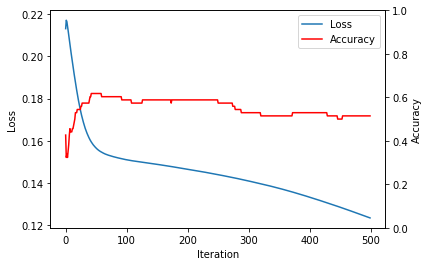

In [6]:
"""
Plot the train loss curve
"""
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(loss_history,label="Loss")
ax2 = ax.twinx()
lns2 = ax2.plot(accuracy_history,"-r",label="Accuracy")

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=0)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

plt.savefig(r"fig/iteration.pdf",format="pdf",dpi=200)
plt.show()

In [7]:
train_data = pd.read_csv("horse-colic.data",names=attr_dict.keys(),index_col=False,delim_whitespace=True)
for a in train_data.columns.values:
    print(train_data[a].value_counts())

1    180
2    119
?      1
Name: surgery, dtype: int64
1    276
9     24
Name: Age, dtype: int64
529796     2
529424     2
5279822    2
527916     2
530526     2
          ..
530255     1
530254     1
533836     1
530251     1
535043     1
Name: Hospital Number, Length: 284, dtype: int64
?        60
38.00    16
37.80    13
38.30    12
38.50    10
         ..
37.6      1
39.60     1
36.5      1
36.60     1
37.4      1
Name: rectal temperature, Length: 66, dtype: int64
48     28
60     25
?      24
40     18
88     12
52     12
44     11
100    11
72     11
120    10
42     10
64      8
84      8
96      8
80      8
54      7
56      7
50      6
66      6
68      5
104     5
70      4
76      4
92      4
90      3
108     3
86      3
78      3
36      3
112     3
114     2
130     2
124     2
140     2
150     2
30      2
45      2
38      1
132     1
46      1
160     1
75      1
128     1
184     1
65      1
146     1
136     1
82      1
129     1
164     1
49      1
98      1
110     